### NLP exploration of Find it Fix It requests to the City of Seattle (from a FOI request)

In [1]:
#getting and working with data
import pandas as pd
import numpy as np
import re
import os
import datetime as dt
import string

#visualizing results
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context("poster")
sns.set_style("dark")
sns.set_style("ticks")
#import yellowbrick as yb

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.text import Text
from nltk.probability import FreqDist

import gensim
from gensim import corpora


In [2]:
#path for FIFI FOI request
path = 'C:/Users/Schindler/Documents/ProgrammingFun/FIFI/zip_filtered_data.pkl'

In [3]:
#read in pkl file containing 
data = pd.read_pickle(path)
data = pd.DataFrame(data = data)
data.reset_index(inplace=True, drop=True)
data.head(1)

,Service_Request_Number,Created_Date,Location,Location_Details,Description,License_Number,State,Vehicle_Make,Vehicle_Color,Time_parked,Photo,FIFI_category,Location_Details.1,Property_damage?,Current_Issue,Type_of_animal,On_private_property?,Graffiti_location,Location_and_Description,Obscene/Racial/Hateful?,Street/Intersection,Where?,Type_of_item?,Veg_location,Vegetation_Safety_Issue,Parking_Violation_Concerning,License_Plate_Number,Location_details,7_digit_number_on_pole,Issue,date,year,month,day,day_of_week,hour,zip,neighborhood
0,13-00036779,2013-05-09 20:32:33,"5208 BEACON AVE S, SEATTLE, WA","5200 Beacon Ave S Seattle, WA 98108; XY: 12775...",Ford light blue,AHZ9829,NaN,Ford,Blue,Over 3 Days,NaN,Abnd_Vehicle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-05-09,2013,5,9,Thursday,20,WA,WA


### Preprocessing

In [4]:
#select zips that have great than 999 entries
zip_counts = data['zip'].value_counts()
zip_counts_1000 = zip_counts[zip_counts > 999].index.values
data_zip_filtered = data[data['zip'].isin(zip_counts_1000)]
print('Combined data final zips: ', '\n', data_zip_filtered['zip'].value_counts(), '\n')

#select FIFI categories that have great than 999 entries
cat_counts = data_zip_filtered['FIFI_category'].value_counts()
cat_counts_1000 = cat_counts[cat_counts > 999].index.values
combined_data_final = data_zip_filtered[data_zip_filtered['FIFI_category'].isin(cat_counts_1000)]
print('Combined data final FIFI categories: ', '\n', combined_data_final['FIFI_category'].value_counts(), '\n') 

Combined data final zips:  
 WA       37881
98103    19454
98107    17402
98144    14212
98118    12933
98105    12860
98108    12091
98122    11870
98115     9121
98102     8639
98117     8622
98109     8445
98125     7962
98133     7789
98104     7314
98106     7256
98112     6511
98119     6164
98199     5724
98134     5328
98126     4598
98101     4417
98116     4089
98121     3185
98136     1610
98178     1147
98177     1076
Name: zip, dtype: int64 

Combined data final FIFI categories:  
 Other              51256
Needles/Dumping    50540
Grafitti           35386
Abnd_Vehicle       35071
Parking            31108
Pothole            23749
Sign/Signal        12123
Streetlight         7682
Name: FIFI_category, dtype: int64 



In [5]:
#sentiment analysis with nltk
#preprocess first

print(combined_data_final.shape)
#only use entries with a description included
zip_filtered_note = combined_data_final[~combined_data_final['Description'].isna()]
print(zip_filtered_note.shape)

#remove punctuation, lowercase words
print('removing punctuation and making lowercase')
zip_filtered_note['entry_clean'] = zip_filtered_note.apply(lambda row: re.sub(r'[^\w\s]','', row['Description']), axis=1)
zip_filtered_note['entry_clean'] = zip_filtered_note['entry_clean'].str.lower()

#tokenize each entry
print('tokenizing')
zip_filtered_note['entry_clean'] = zip_filtered_note.apply(lambda row: word_tokenize(row['entry_clean']), axis=1)

#remove words with fewer than 3 characters

#remove stop words
print('removing stop words')
stop_words=set(stopwords.words("english"))
zip_filtered_note['entry_clean'] = [[w for w in row if w not in stop_words] for row in zip_filtered_note['entry_clean']]

#lemmatize
print('lemmatizing')
lemmatizer = WordNetLemmatizer()
zip_filtered_note['entry_clean'] = [[lemmatizer.lemmatize(w) for w in row] for row in zip_filtered_note['entry_clean']]

# Stemming
print('stemming')
ps = PorterStemmer()
zip_filtered_note['entry_clean'] = [[ps.stem(w) for w in row] for row in zip_filtered_note['entry_clean']]

#part of speech assign
#x = nltk.pos_tag(x)

(246915, 38)
(220240, 38)
removing punctuation and making lowercase
tokenizing
removing stop words
lemmatizing
stemming


In [ ]:
#assign a part of speech (POS) to each word
print('assigning POS')
zip_filtered_note['POS'] = [[nltk.pos_tag(w) for w in row] for row in zip_filtered_note['entry_clean']]

In [40]:
#create list of FIFI cats ordered by request count to use for ordering of x axis on graphs
cat_order = zip_filtered_note['FIFI_category'].value_counts().index.values

#create list of neighborhoods ordered by request count to use for ordering of x axis on graphs
neigh_order = zip_filtered_note['neighborhood'].value_counts().index.values

### Unsupervised sentiment analysis

In [9]:
#use sentiment.vader to get polarity score of each entry
sid = SentimentIntensityAnalyzer()
x_polarity_mean = []
x_polarity_min = []
x_polarity_max = []
for index, row in zip_filtered_note.iterrows():
    #polarity_list = [sid.polarity_scores(w)['compound'] for w in row['entry_clean']]
    x_polarity_mean.append(np.mean(polarity_list))
    try:
        x_polarity_min.append(min(polarity_list))
    except: 
        x_polarity_min.append(np.nan)
    try:
        x_polarity_max.append(max(polarity_list))
    except: 
        x_polarity_max.append(np.nan)
    
zip_filtered_note['x_polarity_mean'] = x_polarity_mean
zip_filtered_note['x_polarity_min'] = x_polarity_min
zip_filtered_note['x_polarity_max'] = x_polarity_max

In [28]:
seperator = ', '
x = sid.polarity_scores(seperator.join(zip_filtered_note.iloc[0]['entry_clean']))
sid.polarity_scores(x)

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [29]:
#use sentiment.vader to get polarity score of each entry
sid = SentimentIntensityAnalyzer()
x_polarity_compound = []
seperator = ', '

for index, row in zip_filtered_note.iterrows():
    #must concat list of strings for each row entry_clean
    polarity = sid.polarity_scores(seperator.join(row['entry_clean']))['compound']
    x_polarity_compound.append(polarity)
    
zip_filtered_note['x_polarity_compound'] = x_polarity_compound

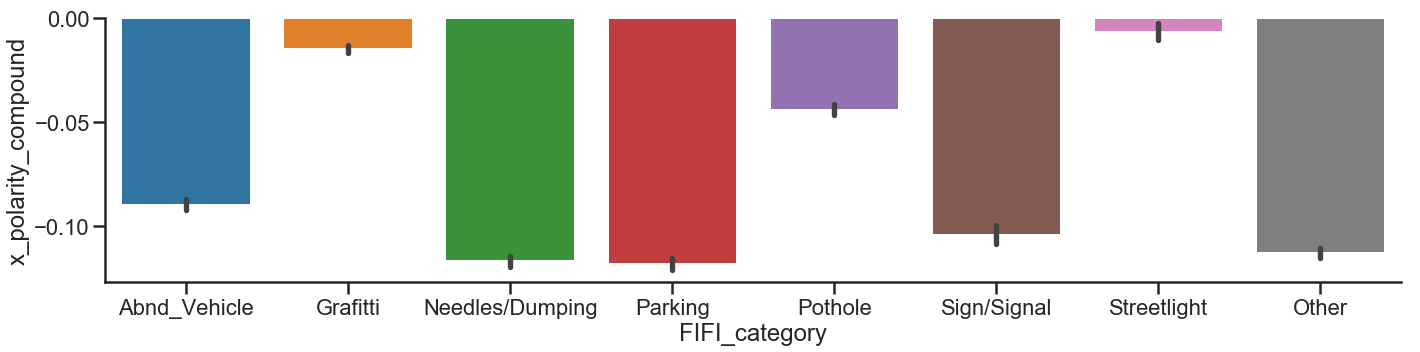

In [36]:
sns.catplot(x='FIFI_category', y='x_polarity_compound', data=zip_filtered_note, kind='bar', height=5, aspect=4)

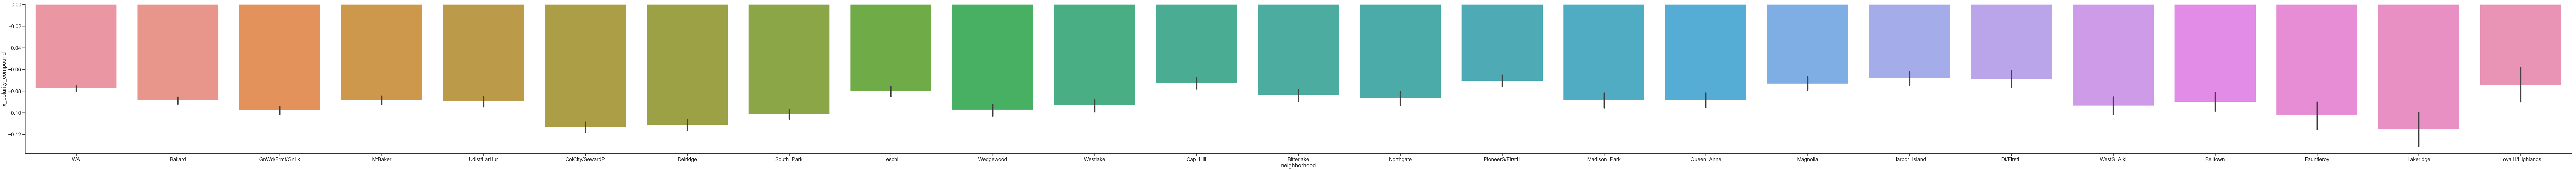

In [49]:
sns.catplot(x='neighborhood', y='x_polarity_compound', data=zip_filtered_note, kind='bar', height=10, aspect=15, order=neigh_order)

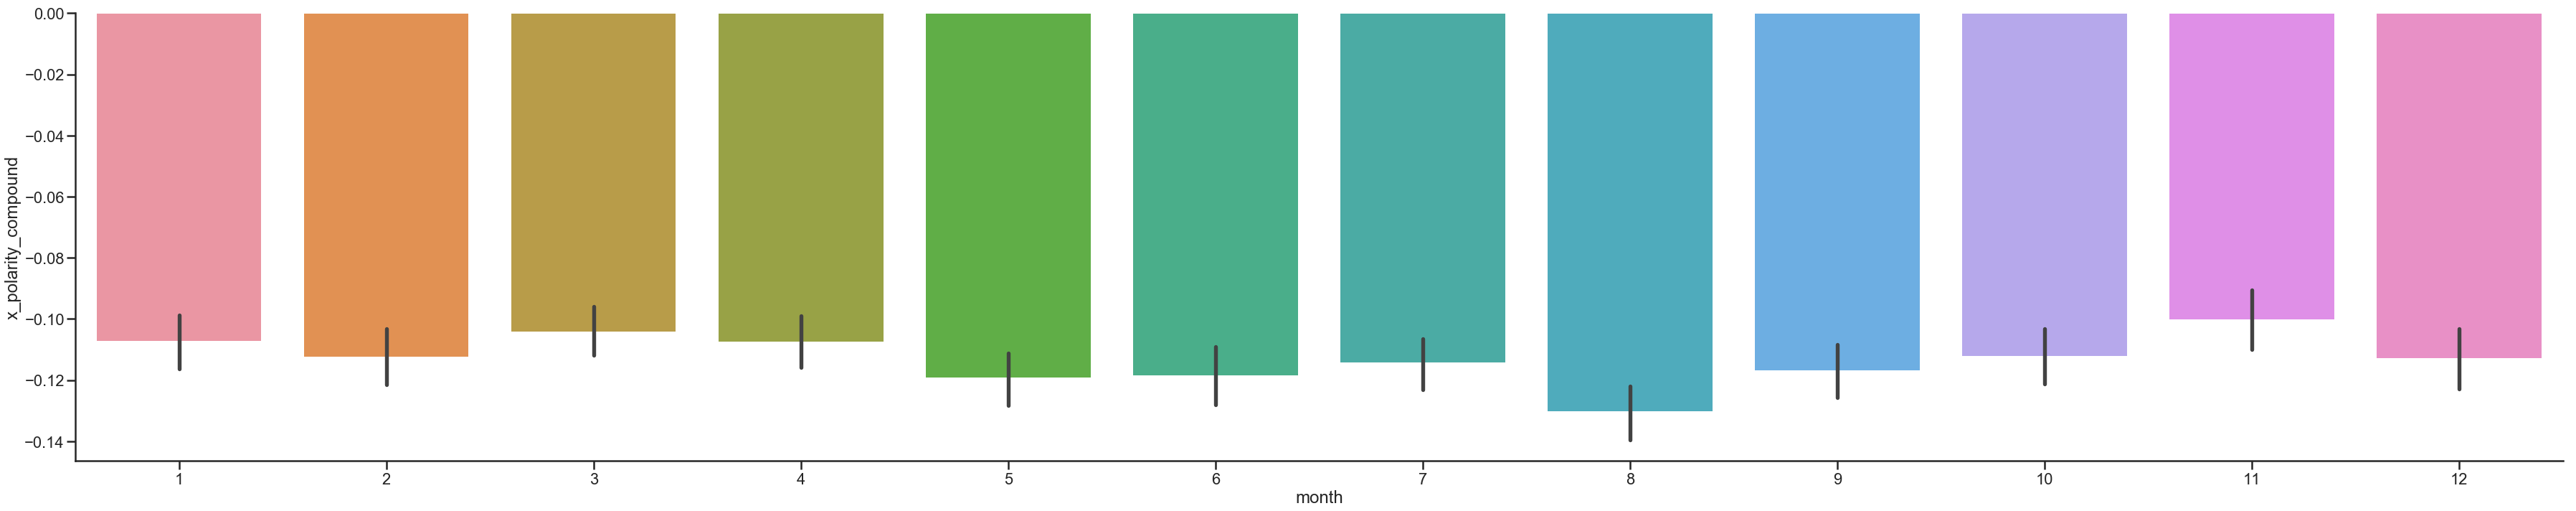

In [58]:
sns.catplot(x='month', y='x_polarity_compound', data=zip_filtered_note[zip_filtered_note['FIFI_category']=='Other'], kind='bar', height=10, aspect=5)

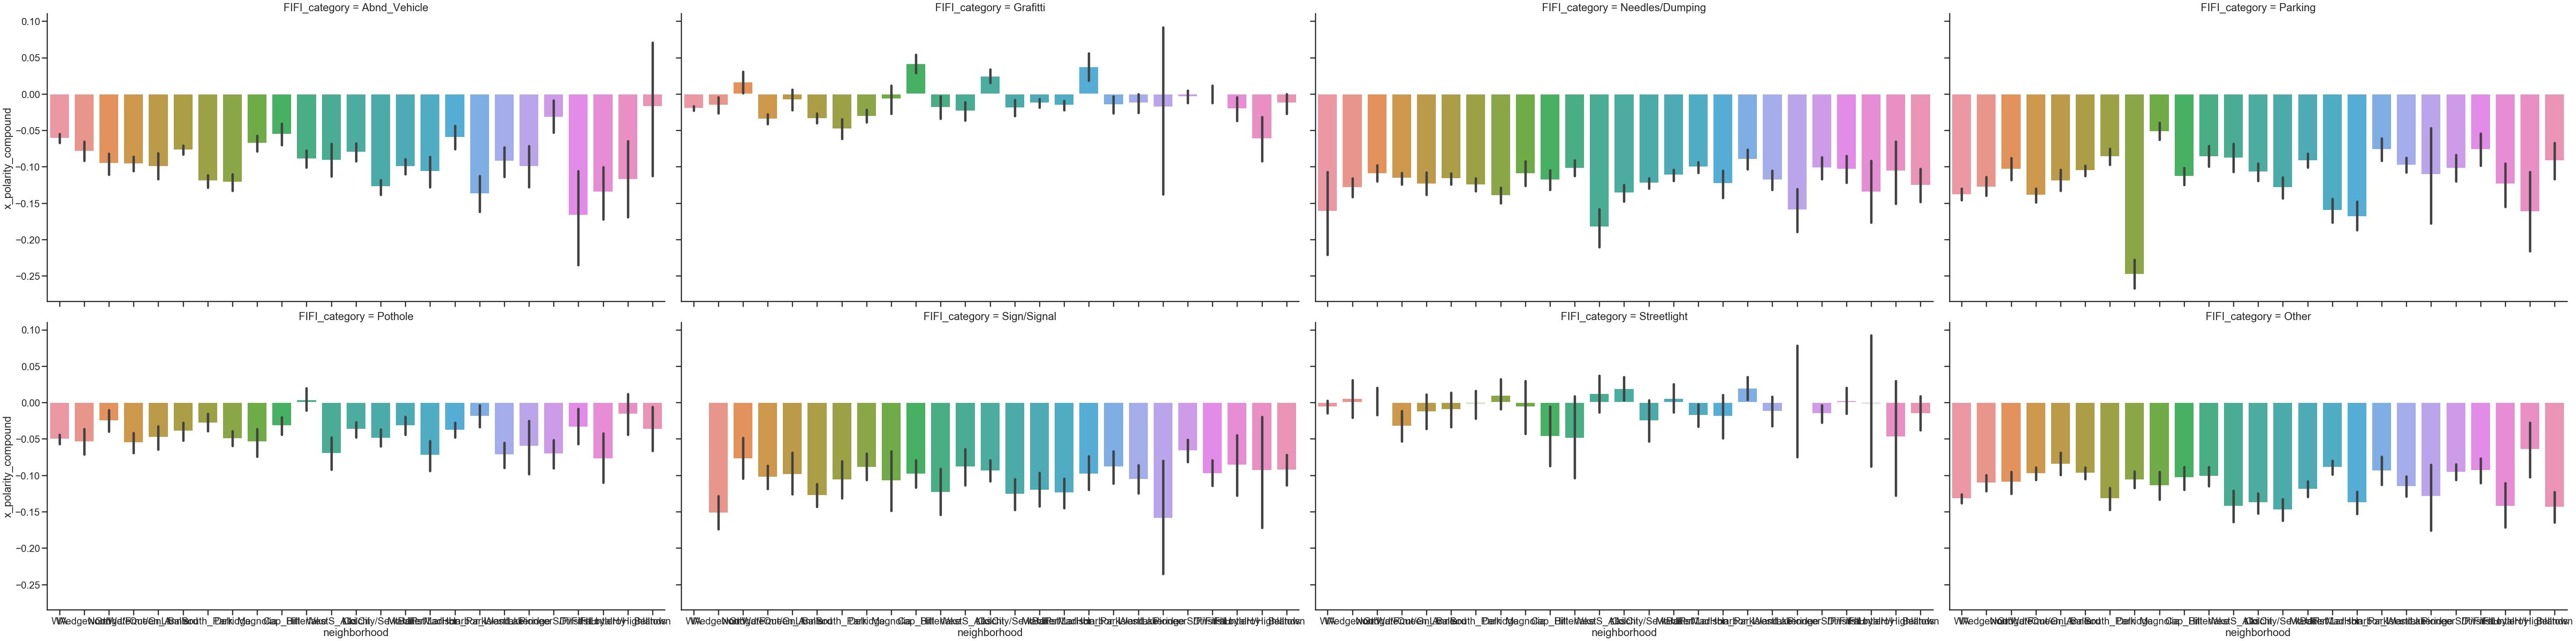

In [31]:
sns.catplot(x='neighborhood', y='x_polarity_compound', data=zip_filtered_note, kind='bar', col='FIFI_category', col_wrap=4, height=10, aspect=2, neigh_order)

### Word frequency exploration

In [ ]:
zip_filtered_groupby = zip_filtered_note.groupby(['FIFI_category'])['entry_clean'].sum(axis=1).reset_index(name='words_clean')
zip_filtered_groupby

In [ ]:
zip_filtered_groupby.head(1)
#len(zip_filtered_groupby.iloc[0]['words_clean'])

In [ ]:
fdist = FreqDist(zip_filtered_groupby.iloc[0]['words_clean'])
print(fdist)


### Topic modeling with LDA

In [ ]:
# Create dictionary
dictionary = corpora.Dictionary(zip_filtered_note['entry_clean'].values)
print(dictionary)

count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

#filter dictionary
dictionary.filter_extremes(no_below=5, no_above=0.1)

#create corpus
bow_corpus = [dictionary.doc2bow(doc) for doc in zip_filtered_note['entry_clean']]

document_num = 20
bow_doc_x = bow_corpus[document_num]

for i in range(len(bow_doc_x)):
    print(bow_doc_x[i][0])
    print(dictionary[bow_doc_x[i][0]])
    print(bow_doc_x[i][1])
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_x[i][0], 
                                                     dictionary[bow_doc_x[i][0]], 
                                                     bow_doc_x[i][1]))

In [ ]:
lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 8, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   workers = 2, alpha = 0.001)

for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")